In [18]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import quimb as qi
import random
from time import time
from scipy.optimize import curve_fit
import pandas as pd


plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15)
plt.rc('figure', titlesize=20)

In [19]:
def genOps(dims):
    """Generate array of operators sigmax, sigmay, sigmaz in numpy array form i th element of sigmaxs is sigmax on the i th site."""
    n = np.max(np.where(np.array(dims) == 2)) + 1  # number of sites
    m = len(dims) - n  # number of vibrational modes

    sigmaxs = []
    sigmays = []
    sigmazs = []

    for i in range(n):
        sigmaxs.append(np.array(qi.ikron(qi.pauli('X'), dims, i)))
        sigmays.append(np.array(qi.ikron(qi.pauli('Y'), dims, i)))
        sigmazs.append(np.array(qi.ikron(qi.pauli('Z'), dims, i)))

    return sigmaxs, sigmays, sigmazs

def genAOps(dims):
    """Generate array of operators a, adag in numpy array form i th element of a is a on the i th mode."""
    n = np.max(np.where(np.array(dims) == 2)) + 1  # number of sites
    m = len(dims) - n  # number of vibrational modes

    a = []
    adag = []

    for i in range(m):
        a.append(np.array(qi.ikron(qi.destroy(dims[n + i]), dims, n + i)))
        adag.append(np.array(qi.ikron(qi.create(dims[n + i]), dims, n + i)))

    return a, adag

def get_Lorentzian(wlist, nu_list, Gamma_list, kappa_list):
    fn = 0
    for i in range(len(nu_list)):
        nu = nu_list[i]
        Gamma = Gamma_list[i]
        fn += kappa_list[i]**2 * Gamma/2 * (1 / ((wlist - nu)**2 + (Gamma/2)**2) - 1 / ((wlist + nu)**2 + (Gamma/2)**2))   
    return fn

In [20]:
sim_time = 12.8 * 2*np.pi
steps = 128
tlist = np.linspace(0, sim_time, steps+1)
tlist_long = np.linspace(0, sim_time, steps*10+1)

Nmax = 10
eps = 0.
Delta = 1.
# IMPORTNAT: nbar_list in increasing mode frequency order. w_list should thus be in decreasing order
nbar_list = np.array([0.1, 0.105, 0.11])  
nu_list =  np.array([1.01, 0.99, 0.97])
Gamma_list = np.array([0.01, 0.03, 0.06]) 
kappa_list = np.array([1., 1., 1.]) * 0.1

beta = np.log(1 + 1/nbar_list[0]) / nu_list[0]
print(beta)

2.3741537354439313


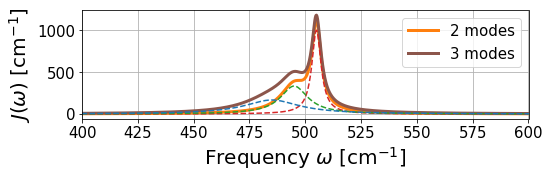

In [21]:
Delta_cm = 500 #cm^-1

# target spectral density
# color_list = ['tab:blue', 'tab:orange', 'tab:green']
color_list = ['tab:red', 'tab:green', 'tab:blue']
wlist = np.linspace(0, 5, 10001)
sd_answer = get_Lorentzian(wlist, nu_list, Gamma_list, kappa_list)
sd_answer2 = get_Lorentzian(wlist, nu_list[:2], Gamma_list[:2], kappa_list[:2])
fig, ax = plt.subplots(1, figsize=(8,2))

ax.plot(wlist[1600:2401]*Delta_cm, sd_answer2[1600:2401]*Delta_cm, color='tab:orange', linewidth = 3, label = '2 modes')
ax.plot(wlist[1600:2401]*Delta_cm, sd_answer[1600:2401]*Delta_cm, color='tab:brown', linewidth = 3, label = '3 modes')
for i in range(len(nu_list)):
    ax.plot(wlist*Delta_cm, Delta_cm*get_Lorentzian(wlist, [nu_list[i]], [Gamma_list[i]], [kappa_list[i]]), '--', color=color_list[i])
ax.set_xlim((0.8*Delta_cm, 1.2*Delta_cm))
ax.set_xlabel(r'Frequency $\omega$ [cm$^{-1}$]')
ax.set_ylabel(r'$J(\omega)$ [cm$^{-1}$]');
ax.grid()
ax.legend(loc='upper right');
# ax.set_ylim((0,3))
plt.savefig('Figure3_1.png', dpi=300, bbox_inches='tight')

In [22]:
# change this part accordingly
mode_freqs = np.array([1.6295, 1.6989, 1.7586, 1.8076, 1.8496, 1.8788, 1.904]) * 2*np.pi * 1e6
pulse_freqs = np.array([1.6295-0.01964, 1.7586-0.01299, 1.8496-0.01064]) * 2*np.pi * 1e6
detuning_std_list = np.array([2.4531405, 2.86639249, 3.39079357]) * 2*np.pi * 1e3

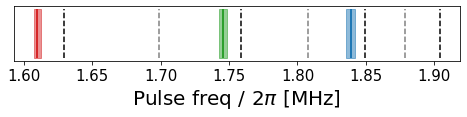

In [23]:
alpha_list = [1, 0.5, 1, 0.5, 1, 0.5, 1]
fig, ax = plt.subplots(1, figsize=(8, 1))
for i in range(len(mode_freqs)):
    ax.vlines(mode_freqs[i]/2/np.pi/1e6, 0, 1, colors='k', linestyles='dashed', alpha=alpha_list[i])
for i in range(len(pulse_freqs)):
    ax.vlines(pulse_freqs[i]/2/np.pi/1e6, 0, 1, lw=2, color=color_list[i])
    ax.fill_between(np.linspace((pulse_freqs[i] - detuning_std_list[i])/2/np.pi/1e6,
                                (pulse_freqs[i] + detuning_std_list[i])/2/np.pi/1e6, 101),
                    np.repeat(0, 101),np.repeat(1, 101), alpha=0.5, color=color_list[i])
ax.set_yticks([])
ax.set_xlabel('Pulse freq / ' + r'$2\pi$' + ' [MHz]');
plt.savefig('Figure3_2.png', dpi=300, bbox_inches='tight')

In [24]:
dims = [2]
for i in range(len(nu_list)):
    dims += [Nmax]
sigmax, sigmay, sigmaz = genOps(dims)
a, adag = genAOps(dims)

H_mat = eps / 2 * sigmaz[0] + Delta / 2 * sigmax[0]
for i in range(len(nu_list)):
    H_mat = H_mat + nu_list[i] * adag[i] @ a[i]
    H_mat = H_mat + kappa_list[i]/2 * sigmaz[0] @ (a[i] + adag[i])
H = Qobj(H_mat, dims=[dims, dims])

init_state = ket2dm(basis(2,0))
for i in range(len(nbar_list)):
    init_state = tensor(init_state, thermal_dm(Nmax, nbar_list[i]))

e_ops_mat = [sigmaz[0]]
e_ops = [Qobj(e_op_mat, dims=[dims, dims]) for e_op_mat in e_ops_mat]

c_ops = []
for i in range(len(Gamma_list)):
    c_op_mat = np.sqrt(Gamma_list[i]) * adag[i] @ a[i]
    c_ops += [Qobj(c_op_mat, dims=[dims, dims])]

# result = mesolve(H, init_state, tlist, e_ops=e_ops, c_ops=c_ops)
# simdata = np.array(result.expect[0] + 1)/2

# np.save('3mode_dephased', simdata) 

In [25]:
simdata = np.load('3mode_fishbone.npy')[:1281]

In [26]:
def readFile(filename):
    timeTickFirst, timeTickLast, x, ion3, ion3_raw, ion3_bottom, ion3_top, ion4, ion4_raw, ion4_bottom, \
    ion4_top, ion5, ion5_raw, ion5_bottom, ion5_top, ion2, ion2_raw, ion2_bottom, ion2_top, ion6, ion6_raw, \
    ion6_bottom, ion6_top\
      = np.loadtxt(filename, comments='#', delimiter='\t', converters=None,
                   skiprows=0,unpack=True, encoding='latin1')
    return x, ion4

def analyze(data_list):
    expdata_all = np.array(data_list).reshape((len(data_list), -1))
    expdata = np.mean(expdata_all, axis=0)
    
    variance = np.std(expdata_all, axis=0)**2 / len(data_list)
    shotnoise = np.maximum(np.sqrt(expdata_all * (1-expdata_all) / 100), 1e-3)
    variance = variance + np.mean(shotnoise**2, axis=0)
    errorbar = np.sqrt(variance)
    
    return expdata, errorbar

data_list = []

for no in np.arange(1, 21).tolist():
    _, pop = readFile('Three_mode_%s'%str(no).zfill(3))
    data_list += [pop[:]]
expdata, errorbar = analyze(data_list)

In [28]:
## Unit conversion ######
Delta_cm = 500 #cm^-1
Delta_eV = Delta_cm/8065.73 # eV
hbar = 6.62607015e-34/2/np.pi
q = 1.60217663e-19
Delta = Delta_eV*q/hbar # Hz * 2pi
print('Delta: 2 pi '+str(Delta/1e12/2/np.pi)+' THz')
scale = 1e15/(Delta/2/np.pi) #1e15 fs / (freq in Hz)
print(scale)
tlist_long = tlist_long*scale
tlist = tlist*scale

Delta: 2 pi 14.989277077512869 THz
66.71435819277866


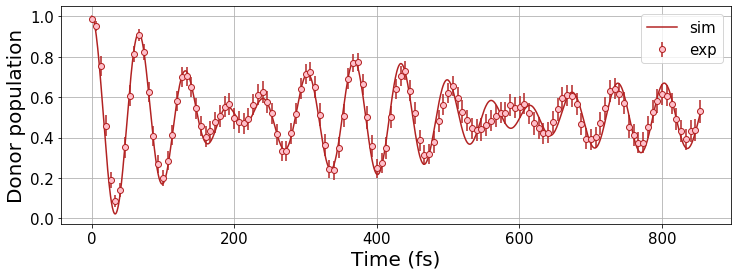

In [30]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(tlist_long/2/np.pi, simdata, '-', color = 'firebrick', label='sim')
ax.errorbar(tlist/2/np.pi, expdata, yerr=errorbar, ls='',color = 'orangered', marker='o',\
            mec='firebrick', ecolor='firebrick',mfc='pink',  label='exp')
ax.set_xlabel(r'Time (fs)')
ax.set_ylabel('Donor population')
ax.grid()
ax.legend()

In [31]:
with open('exp_data_2mode.npy', 'rb') as f:
    tlist_2 = np.load(f)
    expdata_2 = np.load(f)
    errorbar_2 = np.load(f)
simdata_2 = np.load('2mode_fishbone.npy')[:1281]
tlist_long_2 = np.linspace(0, 12.8*2*np.pi, 1281)

tlist_long_2 = tlist_long_2*scale
tlist_2 = tlist_2*scale

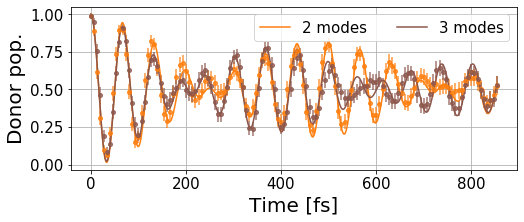

In [33]:
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(tlist_long_2/2/np.pi, simdata_2, '-', color='tab:orange', label='2 modes')
ax.errorbar(tlist_2/2/np.pi, expdata_2, yerr=errorbar_2, fmt='o', alpha=0.8, color='tab:orange',markersize=4)
# ax.plot(tlist/2/np.pi, simdata, '-', color='tab:orange', label='3 mode')
# ax.errorbar(tlist/2/np.pi, expdata, yerr=errorbar, fmt='o', alpha=0.8, color='tab:orange')
ax.plot(tlist_long/2/np.pi, simdata, '-', color='tab:brown', label='3 modes')
ax.errorbar(tlist/2/np.pi, expdata, yerr=errorbar, fmt='o', alpha=0.8, color='tab:brown',markersize=4)
ax.set_xlabel(r'Time [fs]')
ax.set_ylabel('Donor pop.')
ax.grid()
ax.legend(ncol=6);
plt.savefig('Figure3_3.png', dpi=300, bbox_inches='tight')